# Table of Contents

1. [**Problem Description**](#1)
2. [**Gurobi**](#2)
3. [**Reference**](#3)

# 1- Problem Description <a id="1"></a>

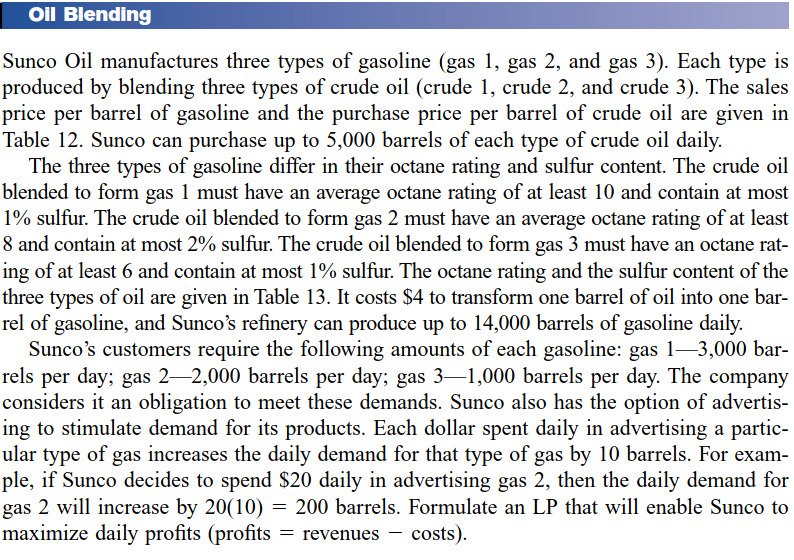

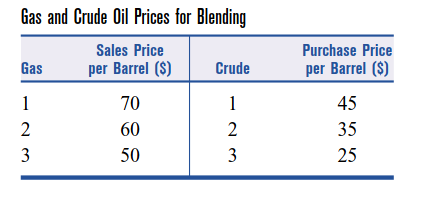

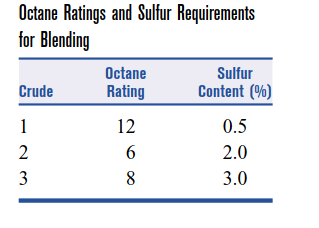

## Mathematical Model

### Sets
I: types of crude oil= {crude1, crude2, crude3}<br>
J: types of gasoline = {gas1, gas2, gas3}<br>
K: types of output quality = {octan, sulfur}


### Parameters
Costs = [45, 35, 25]<br>
Revenues = [70, 60, 50]<br>
Fix_Cost = 4<br>
Ad_Cost = 1<br>
Ad_Effect = 10<br>
Capacity = 14000<br>
Crude Availabe = [5000, 5000, 5000]<br>
Demands = [3000, 2000, 1000]<br>
InputQuality = [[12, 0.5], [6, 2.0], [8, 3.0]]<br>
OutputQuality = [[10, 1],  [6, 2], [8, 1]]<br>

### Decision Variables:
$X_{i,j}$: barrels of crude oil i used daily to produce gas j  $\forall i \in I, \forall j \in J$<br>
$Y_{j}$: dollars spent daily on advertising gas j $\forall j \in J$

### Constraints:
**Constraint1**: Gas 1 produced daily should equal its daily demand.<br>
**Constraint2**: Gas 2 produced daily should equal its daily demand.<br>
**Constraint3**: Gas 3 produced daily should equal its daily demand.<br>
**Constraint4**: At most 5,000 barrels of crude 1 can be purchased daily.<br>
**Constraint5**: At most 5,000 barrels of crude 2 can be purchased daily.<br>
**Constraint6**: At most 5,000 barrels of crude 3 can be purchased daily.<br>
**Constraint7**: Because of limited reﬁnery capacity, at most 14,000 barrels of gasoline can be produced daily.<br>
**Constraint8**: Crude oil blended to make gas 1 must have an average octane level of at least 10.<br>
**Constraint9**: Crude oil blended to make gas 2 must have an average octane level of at least 8.<br>
**Constraint10**: Crude oil blended to make gas 3 must have an average octane level of at least 6.<br>
**Constraint11**: Crude oil blended to make gas 1 must contain at most 1% sulfur.<br>
**Constraint12**: Crude oil blended to make gas 2 must contain at most 2% sulfur.<br>
**Constraint13**: Crude oil blended to make gas 3 must contain at most 1% sulfur.<br>

### Objective Function:
maximize daily proﬁts (proﬁts - revenues - costs).

### Mathematical model formulation

$$\begin{align}
\max Z = &\sum_{i=0}^{I}\sum_{j=0}^{J} (Revenies_{i} - Cost_{j} - FixCost)*X_{i,j} -\sum_{i=0}^{I}AdCost*Y_{i}\\
\text{S.t}\\
&\sum_{i \in I} X_{i,j} - AdEffect*Y_{j} = Demand_{j} &\forall j \in J \text{(for three first constraints)}\\
&\sum_{j \in J} X_{i,j} \leq CrudeAvailabel_{i} &\forall i \in I \text{(for three second constraints)}\\
&\sum_{i \in I, j \in J} X_{i,j} \leq Capacity &\text{(for 7'th constraint)}\\
&\sum_{i \in I} InputQuality_{k,i}*X_{i,j} \ge OutputQuality_{k,j}\sum_{i\in I}*X_{i,j} &k=0, \forall j \in J
\text{(for 8'th, 9'th, and 10'th constraints)}\\
&\sum_{i \in I} InputQuality_{k,i}*X_{i,j} \le OutputQuality_{k,j}\sum_{i\in I}*X_{i,j} &k=1, \forall j \in J
\text{(for three last constraints)}\\
& X_{i,j} \ge 0 &\forall i \in I, \forall j \in J\\
\end{align}$$

# 2- Gurobi <a id="2"></a>

In [1]:
from gurobipy import GRB, Model, quicksum
import numpy as np

## Parameters Definition

In [2]:
Variables = np.array([['Crude1', 'Crude2', 'Crude3'], ['Gas1', 'Gas2', 'Gas3']])

Parameters = {"Revenues"       : [70, 60, 50],
              
              "Costs"          : [45, 35, 25],
              
              "Fix_Cost"       : 4,
              
              "Ad_Cost"        : 1,
              
              "Ad_Effect"      : 10,
              
              "Capacity"       : 14000,
              
              "Demands"        : [3000, 2000, 1000],
              
              "Crude_Availabe" : [5000, 5000, 5000],
              
              "InputQuality"   : np.array([[12, 6, 8],
                                           [0.5, 2.0, 3.0]]),
              
              "OutputQuality"  : np.array([[10, 6, 8],
                                           [1, 2, 1]])
             }

## Model Definition

In [3]:
def output(m):  
    status_code = {1:'LOADED',
                   2: 'OPTIMAL',
                   3:'INFEASIBLE',
                   4:'INF_OR_UNBD',
                   5:'UNBOUNDED'}
    
    status = m.status
    print(f'The optimization status is: {status_code[status]}')
    
    if status == 2:
        print('Optimal solution:')
        for var in m.getVars():
            print(f'{var.varName} = {var.x}')
        print(f'Optimal Objective Function = {m.objVal}')

In [4]:
def Gurobi_Model(Var, Param):
      
    model = Model('Blending')
    
    model.setParam('OutputFlag', True)
    
    revenues, costs, demands, crude_availabe = Param['Revenues'], Param['Costs'],   Param['Demands'],   Param['Crude_Availabe']
    fix_cost, ad_cost, ad_effect, capacity   = Param['Fix_Cost'], Param['Ad_Cost'], Param['Ad_Effect'], Param['Capacity']
    inputquality, outputquality              = Param['InputQuality'],               Param['OutputQuality']
    
    m = len(Var[0])
    n = len(Var[1])
    K = len(inputquality[0])
    
    X = model.addVars(m,n, lb=0, ub=GRB.INFINITY, vtype = GRB.CONTINUOUS)
    Y = model.addVars(n,   lb=0, ub=GRB.INFINITY, vtype = GRB.CONTINUOUS)
    
    model.setObjective( quicksum( (revenues[j] - costs[i] - fix_cost)*X[i,j] for i in range(m) for j in range(n))
                        -ad_cost*Y.sum("*"), GRB.MAXIMIZE)
    
    model.addConstrs(X.sum('*', j) - ad_effect*Y[j] == demands[j] for j in range(n))
    model.addConstrs(X.sum(i, '*') <= crude_availabe[i] for i in range(m))
    model.addConstr (X.sum('*', '*') <= capacity)
    
    model.addConstrs(quicksum(inputquality[k][i]*X[i,j] for i in range(m)) >= outputquality[k][j]*X.sum('*',j)
                     for j in range(m) for k in range(K) if k ==0)
    
    model.addConstrs(quicksum(inputquality[k][i]*X[i,j] for i in range(m)) <= outputquality[k][j]*X.sum('*',j)
                     for j in range(m) for k in range(K) if k ==1)
    
    model.optimize()
    output(model)

In [5]:
Gurobi_Model(Variables, Parameters)

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i5-4210U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 13 rows, 12 columns and 45 nonzeros
Model fingerprint: 0x79e3c1eb
Coefficient statistics:
  Matrix range     [5e-01, 1e+01]
  Objective range  [1e+00, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+04]
Presolve removed 4 rows and 3 columns
Presolve time: 0.03s
Presolved: 9 rows, 9 columns, 33 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.2410000e+05   2.849815e+03   0.000000e+00      0s
      10    2.8775000e+05   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.05 seconds (0.00 work units)
Optimal objective  2.877500000e+05
The optimization status is: OPTIMAL
Optimal solution:
C0 = 2000.0
C1 = 

# 3- Reference <a id='3'></a>
[**Operations Research** Wayne L.Winston, page86](https://itslearningakarmazyan.files.wordpress.com/2015/09/operation-research-aplications-and-algorithms.pdf)